# SNCOSMO Notebook (ZTF, ATLAS & ESO)
table format: time - band - flux - fluxerr - zp - zpsys (df - > astropy-Table)\
ZTF -> 'ab'; zp=8.9\
ATLAS -> also; zp =23.9\
eso -> zp=25, zpsys = vega

In [1]:
import sncosmo
from astropy.table import Table
from matplotlib.pyplot import get_cmap
import pandas as pd
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [2]:
model = sncosmo.Model(source='SALT3-NIR')
""" Get redshift using Wiserep API"""
from wiserep_api import get_target_property

redshift = get_target_property('2019bdz', 'redshift')
model.set(z=redshift)
redshift

0.059374

In [3]:
"""Register filters for ESO images (SOFI is in LaSilla) from svo filters"""
# J-sofi
js_snpy =  f"LaSilla_SOFI.J.dat"
spjs=Table.read(js_snpy, format='ascii', names=('l','t'))
lam_js = spjs["l"]
trans_js = spjs["t"]
jsofi = sncosmo.Bandpass(lam_js, trans_js, name='Jntt')
sncosmo.register(jsofi)

# H-sofi
hs_snpy =  f"LaSilla_SOFI.H.dat"
sphs=Table.read(hs_snpy, format='ascii', names=('l','t'))
lam_hs = sphs["l"]
trans_hs = sphs["t"]
hsofi = sncosmo.Bandpass(lam_hs, trans_hs, name='Hntt')
sncosmo.register(hsofi)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


array([ 5.93740000e-02,  5.85502494e+04,  3.26712949e-03, -5.32970421e-01,
       -1.40007592e-01])

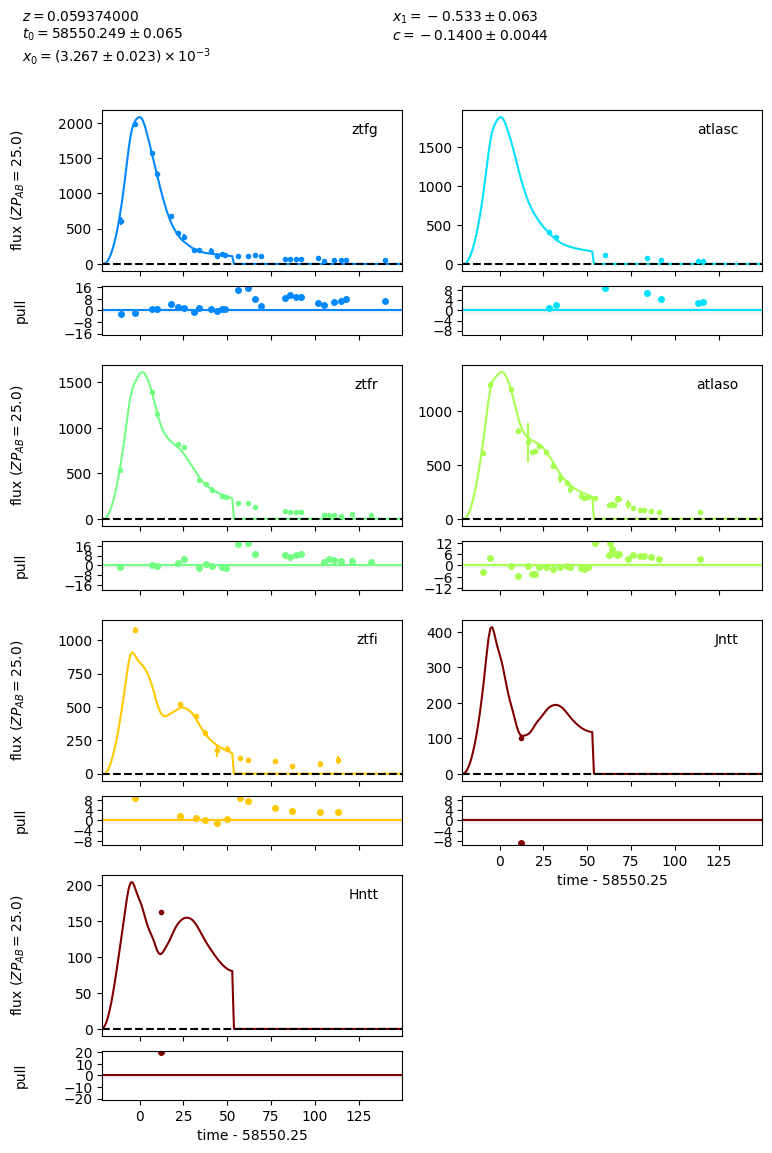

In [17]:
"""Fit the light curves"""

# ATLAS data
df_atlas = pd.read_csv('/Users/j.alcaide/Documents/ICE_FASE2JiC/SNCOSMO/SN2019bdz_atlas_detections.csv')
df_atlas['zp'] = 23.9
df_atlas['zpsys'] = 'ab'
df_atlas["F"] = df_atlas["F"].replace({"o":"atlaso","c":"atlasc"})
df_atlas = df_atlas[["MJD","F","uJy","duJy","zp","zpsys"]]
df_atlas = df_atlas.rename(columns={"MJD":"mjd","F":"filter","uJy": "flux", "duJy":"fluxerr"})

# ZTF data
df_ztf = pd.read_csv('SN2019bdz_ztf_detections_field478_ccdid13_qid2.csv')
df_ztf["zp"] = 8.9
df_ztf["zpsys"] = "ab"
df_ztf = df_ztf[["mjd","filter","flux_ab","flux_ab_sigma","zp","zpsys", "mag_ab", "mag_ab_sigma"]]
df_ztf["filter"] = df_ztf["filter"].replace({"ZTF_g":"ztfg","ZTF_r":"ztfr","ZTF_i":"ztfi"})
df_ztf = df_ztf.rename(columns={"mjd":"mjd","flux_ab": "flux", "flux_ab_sigma": "fluxerr", "mag_ab":"mag", "mag_ab_sigma":"mag_err"})
df_ztf = df_ztf.drop(['mag', 'mag_err'], axis=1)

# SOFI data
df_sofi = pd.read_csv('/Users/j.alcaide/Documents/ICE_FASE2JiC/SNCOSMO/magnitudes.csv')
df_sofi = df_sofi[df_sofi["filter"]!="Kntt"]
df_sofi["zp"] = 25
df_sofi["flux"] = 10**(-0.4*(df_sofi["mag"]- df_sofi["zp"]))
df_sofi["fluxerr"] = 0.4*np.log(10)* (10**(-0.4*(df_sofi["mag"]- df_sofi["zp"])) )*np.sqrt(df_sofi["mag_err"]**2)**2#+ df_sofi["zp_err"])**2
df_sofi["zpsys"] = "vega"
df_sofi = df_sofi[df_sofi["filter"]!="Ks"] # Not using K-filter since SALT3 goes to 20000
df_sofi['filter'] = df_sofi['filter'].replace({'J': 'Jntt', 'H': 'Hntt',  })
df_sofi = df_sofi[["mjd", "filter", "flux","fluxerr", "zp", "zpsys"]]

df_all = pd.concat([df_atlas, df_ztf, df_sofi])
data = Table(np.array(df_all), names=["time", "band", "flux", "fluxerr", "zp", "zpsys"], dtype=('float64', 'str', 'float64', 'float64','float64', 'str'))

result, fitted_model = sncosmo.fit_lc(data, model, ['t0', 'x0', 'x1', 'c',])
plot = sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)
plot.savefig('2019bdz.png')
result['parameters']

In [18]:
"""get peak magnitude"""

bmax = fitted_model.source_peakmag('bessellb', 'vega')
bmaxerr = 2.5 / np.log(10) * result.errors['x0'] / result.parameters[2]

babs = fitted_model.source_peakabsmag('bessellb', 'vega')

params = result['parameters']
errors = result["errors"]
t0 = params[1]
x0 = params[2]
x1 = params[3]
c = params[4]
t0err = errors["t0"]
x0err = errors["x0"]
x1err = errors["x1"]
cerr = errors["c"]

alpha, beta = 0.161, 3.12 # DES 5 year values
alpha_err, beta_err = 0.001, 0.003

dm = bmax-babs + alpha*x1 -beta*c
dmerr = np.sqrt(bmaxerr**2 + (x1*alpha_err)**2 + (x1err*alpha)**2 + (c*beta_err)**2 + (beta*cerr)**2 )
dm, dmerr

(37.49579072490789, 0.01866623901379569)